# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [4]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

# Imports

In [5]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 100
BATCH_SIZE = 8

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1.5e-5
WEIGHT_DECAY = 0.05
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

IMG_MEANS = [
        494.905781,
        815.239594,
        924.335066,
        2968.881459,
        2634.621962,
        1739.579917,
        494.905781,
        815.239594,
        924.335066,
        2968.881459,
        2634.621962,
        1739.579917,
        494.905781,
        815.239594,
        924.335066,
        2968.881459,
        2634.621962,
        1739.579917 ]

IMG_STDS = [
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808,
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808,
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808,
]

In [8]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):

        for i in range(image.shape[0]):
                image[i] = (image[i] - IMG_MEANS[i]) / IMG_STDS[i]
        return image

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)

        if(self.transform):

            if random.random() < 0.5:
                image = torch.flip(image, dims=[2])  # flip W
                mask  = torch.flip(mask,  dims=[1])

            if random.random() < 0.5:
                image = torch.flip(image, dims=[1])  # flip H
                mask  = torch.flip(mask,  dims=[0])


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=True
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

tensor([[[-0.6419, -0.6560, -0.6560,  ...,  0.8356,  0.6988, -0.1015],
         [-0.6244, -0.6384, -0.6595,  ..., -0.1681, -0.2453, -0.4033],
         [-0.6490, -0.6525, -0.6630,  ...,  0.3127, -0.4208, -0.5296],
         ...,
         [ 1.4814,  1.4709,  1.4218,  ...,  0.6988,  0.6286,  0.5338],
         [ 1.0392,  1.0567,  1.0638,  ...,  0.7339,  0.6672,  0.6952],
         [-0.1050, -0.1541, -0.1436,  ...,  0.7198,  0.6952,  0.6531]],

        [[-1.0095, -1.0318, -1.0318,  ...,  0.7930,  0.6169,  0.0888],
         [-1.0095, -1.0318, -1.0290,  ..., -0.0370, -0.1152, -0.2326],
         [-1.0402, -1.0514, -1.0458,  ...,  0.3542, -0.2997, -0.3919],
         ...,
         [ 1.1227,  1.1087,  1.0473,  ...,  0.3738,  0.2983,  0.2033],
         [ 0.8097,  0.8293,  0.7986,  ...,  0.4213,  0.3375,  0.3794],
         [-0.0426, -0.0957, -0.0817,  ...,  0.4073,  0.3626,  0.3291]],

        [[-0.8901, -0.9040, -0.8971,  ...,  0.7031,  0.5189, -0.3741],
         [-0.8815, -0.8936, -0.8971,  ..., -0

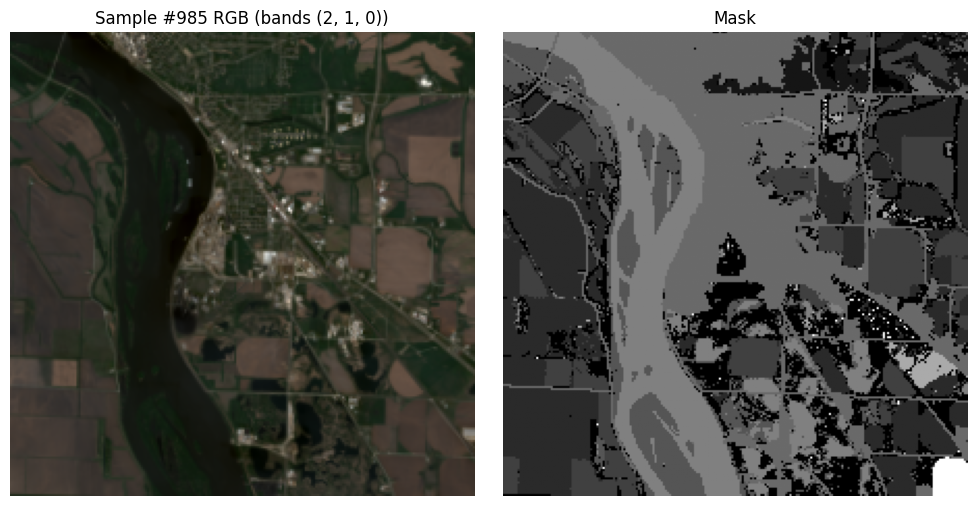

tensor([[[ 4.9871e-01,  5.3731e-01,  3.6183e-01,  ..., -3.9977e-01,
          -4.5593e-01, -4.5593e-01],
         [ 7.0578e-01,  6.4962e-01,  5.1626e-01,  ..., -4.4540e-01,
          -4.7348e-01, -4.6295e-01],
         [ 3.8991e-01,  4.7414e-01,  2.7409e-01,  ..., -5.1559e-01,
          -5.7175e-01, -5.5420e-01],
         ...,
         [-8.7412e-02, -2.4237e-02,  3.8403e-03,  ..., -3.5064e-01,
          -2.0674e-01,  2.0740e-01],
         [ 3.5428e-02,  3.5428e-02,  6.7015e-02,  ..., -4.7348e-01,
          -3.6468e-01, -1.5410e-01],
         [ 1.0913e-01,  1.4774e-01,  1.5125e-01,  ..., -5.4718e-01,
          -4.9805e-01, -3.9275e-01]],

        [[ 3.2908e-01,  3.7658e-01,  1.5862e-01,  ..., -8.4740e-01,
          -8.7534e-01, -8.6416e-01],
         [ 5.4425e-01,  5.2469e-01,  3.6820e-01,  ..., -8.9211e-01,
          -9.2844e-01, -9.1167e-01],
         [ 2.3407e-01,  3.4305e-01,  6.9192e-02,  ..., -9.6197e-01,
          -1.0598e+00, -1.0290e+00],
         ...,
         [-1.7113e-01, -8

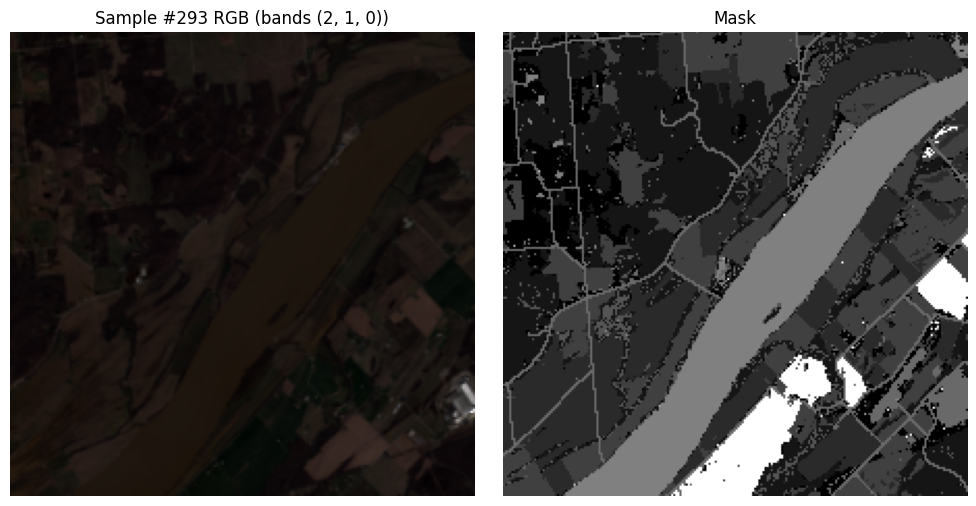

In [9]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [10]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)


class_weights = torch.tensor( [ 0, 0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702], device = DEVICE)
ce_loss = nn.CrossEntropyLoss(
    weight=class_weights,
    ignore_index=0
)

def criterion(preds, targets):
    targets = targets.long()

    L_ce = ce_loss(preds, targets)

    return 1 * L_ce



optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )

def lr_lambda(cur_step):
    if cur_step < 1500:
        return cur_step / 1500 * (1 - 1e-6) + 1e-6
    else:
        return (1 - (cur_step - 1500) / (max_iters - 1500)) ** 1.0

max_iters = len(train_loader) * EPOCHS
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [11]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/100: 100%|██████████| 309/309 [11:45<00:00,  2.28s/it]


[Epoch  0] Loss:  2.7276, Acc:   0.0511, IoU:   0.0220, Dice:  0.0297, mIoU:  0.0173


Epoch 1/100 [Val]: 100%|██████████| 78/78 [02:03<00:00,  1.58s/it]


[Epoch  0] Loss: 2.7470, Acc: 0.0499, IoU: 0.0202, Dice: 0.0255, mIoU: 0.0147


Epoch 2/100: 100%|██████████| 309/309 [06:18<00:00,  1.22s/it]


[Epoch  1] Loss:  2.7275, Acc:   0.0516, IoU:   0.0221, Dice:  0.0298, mIoU:  0.0174


Epoch 2/100 [Val]: 100%|██████████| 78/78 [01:25<00:00,  1.10s/it]


[Epoch  1] Loss: 2.7232, Acc: 0.0478, IoU: 0.0198, Dice: 0.0248, mIoU: 0.0143


Epoch 3/100: 100%|██████████| 309/309 [06:24<00:00,  1.24s/it]


[Epoch  2] Loss:  2.7260, Acc:   0.0509, IoU:   0.0221, Dice:  0.0297, mIoU:  0.0174


Epoch 3/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.10it/s]


[Epoch  2] Loss: 2.7237, Acc: 0.0482, IoU: 0.0190, Dice: 0.0239, mIoU: 0.0138


Epoch 4/100: 100%|██████████| 309/309 [06:10<00:00,  1.20s/it]


[Epoch  3] Loss:  2.7260, Acc:   0.0512, IoU:   0.0220, Dice:  0.0297, mIoU:  0.0173


Epoch 4/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch  3] Loss: 2.7718, Acc: 0.0537, IoU: 0.0214, Dice: 0.0266, mIoU: 0.0154


Epoch 5/100: 100%|██████████| 309/309 [06:18<00:00,  1.23s/it]


[Epoch  4] Loss:  2.7232, Acc:   0.0522, IoU:   0.0225, Dice:  0.0301, mIoU:  0.0176


Epoch 5/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch  4] Loss: 2.7449, Acc: 0.0517, IoU: 0.0208, Dice: 0.0255, mIoU: 0.0148


Epoch 6/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch  5] Loss:  2.7213, Acc:   0.0522, IoU:   0.0224, Dice:  0.0299, mIoU:  0.0175


Epoch 6/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch  5] Loss: 2.7138, Acc: 0.0502, IoU: 0.0190, Dice: 0.0235, mIoU: 0.0136


Epoch 7/100: 100%|██████████| 309/309 [06:12<00:00,  1.20s/it]


[Epoch  6] Loss:  2.7208, Acc:   0.0525, IoU:   0.0226, Dice:  0.0302, mIoU:  0.0177


Epoch 7/100 [Val]: 100%|██████████| 78/78 [01:09<00:00,  1.12it/s]


[Epoch  6] Loss: 2.7370, Acc: 0.0523, IoU: 0.0204, Dice: 0.0249, mIoU: 0.0144


Epoch 8/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch  7] Loss:  2.7206, Acc:   0.0523, IoU:   0.0224, Dice:  0.0301, mIoU:  0.0176


Epoch 8/100 [Val]: 100%|██████████| 78/78 [01:26<00:00,  1.11s/it]


[Epoch  7] Loss: 2.7322, Acc: 0.0527, IoU: 0.0204, Dice: 0.0254, mIoU: 0.0148


Epoch 9/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch  8] Loss:  2.7205, Acc:   0.0528, IoU:   0.0226, Dice:  0.0302, mIoU:  0.0177


Epoch 9/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch  8] Loss: 2.7356, Acc: 0.0535, IoU: 0.0209, Dice: 0.0261, mIoU: 0.0151


Epoch 10/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch  9] Loss:  2.7194, Acc:   0.0528, IoU:   0.0226, Dice:  0.0303, mIoU:  0.0177


Epoch 10/100 [Val]: 100%|██████████| 78/78 [01:20<00:00,  1.03s/it]


[Epoch  9] Loss: 2.7546, Acc: 0.0555, IoU: 0.0218, Dice: 0.0270, mIoU: 0.0156


Epoch 11/100: 100%|██████████| 309/309 [05:45<00:00,  1.12s/it]


[Epoch 10] Loss:  2.7173, Acc:   0.0532, IoU:   0.0228, Dice:  0.0304, mIoU:  0.0178


Epoch 11/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.18s/it]


[Epoch 10] Loss: 2.7362, Acc: 0.0535, IoU: 0.0215, Dice: 0.0265, mIoU: 0.0153


Epoch 12/100: 100%|██████████| 309/309 [05:52<00:00,  1.14s/it]


[Epoch 11] Loss:  2.7166, Acc:   0.0535, IoU:   0.0229, Dice:  0.0305, mIoU:  0.0178


Epoch 12/100 [Val]: 100%|██████████| 78/78 [01:09<00:00,  1.13it/s]


[Epoch 11] Loss: 2.7408, Acc: 0.0548, IoU: 0.0217, Dice: 0.0267, mIoU: 0.0155


Epoch 13/100: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 12] Loss:  2.7151, Acc:   0.0536, IoU:   0.0230, Dice:  0.0305, mIoU:  0.0178


Epoch 13/100 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 12] Loss: 2.7358, Acc: 0.0561, IoU: 0.0220, Dice: 0.0269, mIoU: 0.0156


Epoch 14/100: 100%|██████████| 309/309 [05:59<00:00,  1.17s/it]


[Epoch 13] Loss:  2.7131, Acc:   0.0548, IoU:   0.0232, Dice:  0.0308, mIoU:  0.0180


Epoch 14/100 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.18s/it]


[Epoch 13] Loss: 2.7169, Acc: 0.0532, IoU: 0.0213, Dice: 0.0262, mIoU: 0.0152


Epoch 15/100: 100%|██████████| 309/309 [05:40<00:00,  1.10s/it]


[Epoch 14] Loss:  2.7135, Acc:   0.0544, IoU:   0.0231, Dice:  0.0307, mIoU:  0.0179


Epoch 15/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 14] Loss: 2.7161, Acc: 0.0555, IoU: 0.0215, Dice: 0.0262, mIoU: 0.0152


Epoch 16/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 15] Loss:  2.7117, Acc:   0.0552, IoU:   0.0235, Dice:  0.0309, mIoU:  0.0181


Epoch 16/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 15] Loss: 2.7166, Acc: 0.0569, IoU: 0.0218, Dice: 0.0264, mIoU: 0.0153


Epoch 17/100: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it]


[Epoch 16] Loss:  2.7104, Acc:   0.0550, IoU:   0.0234, Dice:  0.0309, mIoU:  0.0180


Epoch 17/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.11it/s]


[Epoch 16] Loss: 2.7225, Acc: 0.0558, IoU: 0.0211, Dice: 0.0253, mIoU: 0.0146


Epoch 18/100: 100%|██████████| 309/309 [06:34<00:00,  1.28s/it]


[Epoch 17] Loss:  2.7092, Acc:   0.0554, IoU:   0.0236, Dice:  0.0311, mIoU:  0.0182


Epoch 18/100 [Val]: 100%|██████████| 78/78 [01:13<00:00,  1.06it/s]


[Epoch 17] Loss: 2.7020, Acc: 0.0551, IoU: 0.0212, Dice: 0.0258, mIoU: 0.0149


Epoch 19/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 18] Loss:  2.7092, Acc:   0.0557, IoU:   0.0236, Dice:  0.0310, mIoU:  0.0181


Epoch 19/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 18] Loss: 2.7042, Acc: 0.0545, IoU: 0.0211, Dice: 0.0252, mIoU: 0.0146


Epoch 20/100: 100%|██████████| 309/309 [06:06<00:00,  1.18s/it]


[Epoch 19] Loss:  2.7071, Acc:   0.0556, IoU:   0.0237, Dice:  0.0311, mIoU:  0.0181


Epoch 20/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


[Epoch 19] Loss: 2.7221, Acc: 0.0540, IoU: 0.0217, Dice: 0.0262, mIoU: 0.0151


Epoch 21/100: 100%|██████████| 309/309 [06:17<00:00,  1.22s/it]


[Epoch 20] Loss:  2.7068, Acc:   0.0555, IoU:   0.0236, Dice:  0.0311, mIoU:  0.0182


Epoch 21/100 [Val]: 100%|██████████| 78/78 [01:09<00:00,  1.13it/s]


[Epoch 20] Loss: 2.7171, Acc: 0.0580, IoU: 0.0233, Dice: 0.0283, mIoU: 0.0164


Epoch 22/100: 100%|██████████| 309/309 [06:28<00:00,  1.26s/it]


[Epoch 21] Loss:  2.7060, Acc:   0.0570, IoU:   0.0241, Dice:  0.0314, mIoU:  0.0184


Epoch 22/100 [Val]: 100%|██████████| 78/78 [01:25<00:00,  1.09s/it]


[Epoch 21] Loss: 2.7024, Acc: 0.0589, IoU: 0.0221, Dice: 0.0260, mIoU: 0.0151


Epoch 23/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 22] Loss:  2.7046, Acc:   0.0565, IoU:   0.0241, Dice:  0.0314, mIoU:  0.0184


Epoch 23/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 22] Loss: 2.7065, Acc: 0.0602, IoU: 0.0232, Dice: 0.0279, mIoU: 0.0162


Epoch 24/100: 100%|██████████| 309/309 [06:16<00:00,  1.22s/it]


[Epoch 23] Loss:  2.7045, Acc:   0.0574, IoU:   0.0242, Dice:  0.0315, mIoU:  0.0184


Epoch 24/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.27s/it]


[Epoch 23] Loss: 2.6873, Acc: 0.0560, IoU: 0.0194, Dice: 0.0234, mIoU: 0.0135


Epoch 25/100: 100%|██████████| 309/309 [05:38<00:00,  1.09s/it]


[Epoch 24] Loss:  2.7020, Acc:   0.0575, IoU:   0.0243, Dice:  0.0316, mIoU:  0.0185


Epoch 25/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 24] Loss: 2.7190, Acc: 0.0599, IoU: 0.0225, Dice: 0.0271, mIoU: 0.0157


Epoch 26/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 25] Loss:  2.7020, Acc:   0.0574, IoU:   0.0243, Dice:  0.0317, mIoU:  0.0185


Epoch 26/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 25] Loss: 2.6998, Acc: 0.0593, IoU: 0.0226, Dice: 0.0268, mIoU: 0.0155


Epoch 27/100: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it]


[Epoch 26] Loss:  2.7020, Acc:   0.0575, IoU:   0.0244, Dice:  0.0317, mIoU:  0.0185


Epoch 27/100 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.05s/it]


[Epoch 26] Loss: 2.7104, Acc: 0.0591, IoU: 0.0224, Dice: 0.0260, mIoU: 0.0150


Epoch 28/100: 100%|██████████| 309/309 [06:29<00:00,  1.26s/it]


[Epoch 27] Loss:  2.7016, Acc:   0.0574, IoU:   0.0244, Dice:  0.0317, mIoU:  0.0185


Epoch 28/100 [Val]: 100%|██████████| 78/78 [01:11<00:00,  1.10it/s]


[Epoch 27] Loss: 2.7000, Acc: 0.0617, IoU: 0.0243, Dice: 0.0292, mIoU: 0.0169


Epoch 29/100: 100%|██████████| 309/309 [06:12<00:00,  1.21s/it]


[Epoch 28] Loss:  2.6992, Acc:   0.0586, IoU:   0.0247, Dice:  0.0320, mIoU:  0.0187


Epoch 29/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 28] Loss: 2.6952, Acc: 0.0565, IoU: 0.0220, Dice: 0.0262, mIoU: 0.0152


Epoch 30/100: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it]


[Epoch 29] Loss:  2.6989, Acc:   0.0584, IoU:   0.0248, Dice:  0.0320, mIoU:  0.0187


Epoch 30/100 [Val]: 100%|██████████| 78/78 [01:23<00:00,  1.07s/it]


[Epoch 29] Loss: 2.7018, Acc: 0.0589, IoU: 0.0229, Dice: 0.0267, mIoU: 0.0155


Epoch 31/100: 100%|██████████| 309/309 [06:26<00:00,  1.25s/it]


[Epoch 30] Loss:  2.6973, Acc:   0.0584, IoU:   0.0247, Dice:  0.0319, mIoU:  0.0187


Epoch 31/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 30] Loss: 2.7168, Acc: 0.0608, IoU: 0.0230, Dice: 0.0269, mIoU: 0.0156


Epoch 32/100: 100%|██████████| 309/309 [06:10<00:00,  1.20s/it]


[Epoch 31] Loss:  2.6966, Acc:   0.0593, IoU:   0.0250, Dice:  0.0321, mIoU:  0.0188


Epoch 32/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.24s/it]


[Epoch 31] Loss: 2.7017, Acc: 0.0611, IoU: 0.0238, Dice: 0.0275, mIoU: 0.0159


Epoch 33/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch 32] Loss:  2.6951, Acc:   0.0595, IoU:   0.0251, Dice:  0.0322, mIoU:  0.0188


Epoch 33/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 32] Loss: 2.6833, Acc: 0.0607, IoU: 0.0223, Dice: 0.0257, mIoU: 0.0149


Epoch 34/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 33] Loss:  2.6948, Acc:   0.0594, IoU:   0.0251, Dice:  0.0323, mIoU:  0.0189


Epoch 34/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 33] Loss: 2.6897, Acc: 0.0605, IoU: 0.0223, Dice: 0.0262, mIoU: 0.0152


Epoch 35/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 34] Loss:  2.6944, Acc:   0.0600, IoU:   0.0253, Dice:  0.0324, mIoU:  0.0189


Epoch 35/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 34] Loss: 2.6920, Acc: 0.0628, IoU: 0.0247, Dice: 0.0293, mIoU: 0.0170


Epoch 36/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 35] Loss:  2.6943, Acc:   0.0602, IoU:   0.0253, Dice:  0.0323, mIoU:  0.0189


Epoch 36/100 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 35] Loss: 2.6722, Acc: 0.0642, IoU: 0.0224, Dice: 0.0259, mIoU: 0.0150


Epoch 37/100: 100%|██████████| 309/309 [06:25<00:00,  1.25s/it]


[Epoch 36] Loss:  2.6922, Acc:   0.0601, IoU:   0.0255, Dice:  0.0325, mIoU:  0.0190


Epoch 37/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.16it/s]


[Epoch 36] Loss: 2.6858, Acc: 0.0644, IoU: 0.0246, Dice: 0.0291, mIoU: 0.0169


Epoch 38/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch 37] Loss:  2.6915, Acc:   0.0604, IoU:   0.0256, Dice:  0.0325, mIoU:  0.0190


Epoch 38/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 37] Loss: 2.6911, Acc: 0.0636, IoU: 0.0237, Dice: 0.0277, mIoU: 0.0160


Epoch 39/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch 38] Loss:  2.6904, Acc:   0.0610, IoU:   0.0258, Dice:  0.0329, mIoU:  0.0192


Epoch 39/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 38] Loss: 2.6836, Acc: 0.0651, IoU: 0.0226, Dice: 0.0261, mIoU: 0.0152


Epoch 40/100: 100%|██████████| 309/309 [05:36<00:00,  1.09s/it]


[Epoch 39] Loss:  2.6891, Acc:   0.0612, IoU:   0.0258, Dice:  0.0328, mIoU:  0.0191


Epoch 40/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 39] Loss: 2.6844, Acc: 0.0643, IoU: 0.0240, Dice: 0.0281, mIoU: 0.0163


Epoch 41/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch 40] Loss:  2.6886, Acc:   0.0623, IoU:   0.0261, Dice:  0.0330, mIoU:  0.0193


Epoch 41/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 40] Loss: 2.6816, Acc: 0.0649, IoU: 0.0234, Dice: 0.0270, mIoU: 0.0157


Epoch 42/100: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 41] Loss:  2.6873, Acc:   0.0626, IoU:   0.0264, Dice:  0.0331, mIoU:  0.0194


Epoch 42/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.16it/s]


[Epoch 41] Loss: 2.6774, Acc: 0.0641, IoU: 0.0238, Dice: 0.0276, mIoU: 0.0161


Epoch 43/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 42] Loss:  2.6872, Acc:   0.0621, IoU:   0.0261, Dice:  0.0330, mIoU:  0.0193


Epoch 43/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 42] Loss: 2.6979, Acc: 0.0675, IoU: 0.0259, Dice: 0.0302, mIoU: 0.0176


Epoch 44/100: 100%|██████████| 309/309 [06:05<00:00,  1.18s/it]


[Epoch 43] Loss:  2.6869, Acc:   0.0619, IoU:   0.0262, Dice:  0.0331, mIoU:  0.0194


Epoch 44/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 43] Loss: 2.6680, Acc: 0.0670, IoU: 0.0241, Dice: 0.0276, mIoU: 0.0161


Epoch 45/100: 100%|██████████| 309/309 [06:05<00:00,  1.18s/it]


[Epoch 44] Loss:  2.6857, Acc:   0.0624, IoU:   0.0264, Dice:  0.0333, mIoU:  0.0194


Epoch 45/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 44] Loss: 2.6835, Acc: 0.0665, IoU: 0.0242, Dice: 0.0269, mIoU: 0.0156


Epoch 46/100: 100%|██████████| 309/309 [06:05<00:00,  1.18s/it]


[Epoch 45] Loss:  2.6850, Acc:   0.0632, IoU:   0.0265, Dice:  0.0332, mIoU:  0.0194


Epoch 46/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 45] Loss: 2.6816, Acc: 0.0664, IoU: 0.0243, Dice: 0.0278, mIoU: 0.0162


Epoch 47/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch 46] Loss:  2.6833, Acc:   0.0627, IoU:   0.0265, Dice:  0.0333, mIoU:  0.0195


Epoch 47/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 46] Loss: 2.6859, Acc: 0.0674, IoU: 0.0260, Dice: 0.0295, mIoU: 0.0172


Epoch 48/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 47] Loss:  2.6832, Acc:   0.0635, IoU:   0.0267, Dice:  0.0335, mIoU:  0.0196


Epoch 48/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 47] Loss: 2.6763, Acc: 0.0671, IoU: 0.0241, Dice: 0.0273, mIoU: 0.0159


Epoch 49/100: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 48] Loss:  2.6834, Acc:   0.0637, IoU:   0.0268, Dice:  0.0334, mIoU:  0.0196


Epoch 49/100 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 48] Loss: 2.6988, Acc: 0.0700, IoU: 0.0263, Dice: 0.0295, mIoU: 0.0172


Epoch 50/100: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 49] Loss:  2.6807, Acc:   0.0643, IoU:   0.0271, Dice:  0.0338, mIoU:  0.0198


Epoch 50/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 49] Loss: 2.7008, Acc: 0.0712, IoU: 0.0271, Dice: 0.0307, mIoU: 0.0178


Epoch 51/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch 50] Loss:  2.6796, Acc:   0.0650, IoU:   0.0273, Dice:  0.0340, mIoU:  0.0199


Epoch 51/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 50] Loss: 2.6809, Acc: 0.0698, IoU: 0.0249, Dice: 0.0278, mIoU: 0.0162


Epoch 52/100: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it]


[Epoch 51] Loss:  2.6790, Acc:   0.0654, IoU:   0.0272, Dice:  0.0337, mIoU:  0.0197


Epoch 52/100 [Val]: 100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


[Epoch 51] Loss: 2.6853, Acc: 0.0722, IoU: 0.0262, Dice: 0.0296, mIoU: 0.0173


Epoch 53/100: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it]


[Epoch 52] Loss:  2.6796, Acc:   0.0648, IoU:   0.0273, Dice:  0.0340, mIoU:  0.0199


Epoch 53/100 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 52] Loss: 2.6846, Acc: 0.0678, IoU: 0.0249, Dice: 0.0280, mIoU: 0.0163


Epoch 54/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 53] Loss:  2.6781, Acc:   0.0649, IoU:   0.0274, Dice:  0.0339, mIoU:  0.0198


Epoch 54/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 53] Loss: 2.6730, Acc: 0.0710, IoU: 0.0274, Dice: 0.0307, mIoU: 0.0179


Epoch 55/100: 100%|██████████| 309/309 [06:10<00:00,  1.20s/it]


[Epoch 54] Loss:  2.6776, Acc:   0.0653, IoU:   0.0275, Dice:  0.0340, mIoU:  0.0199


Epoch 55/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 54] Loss: 2.6777, Acc: 0.0701, IoU: 0.0262, Dice: 0.0294, mIoU: 0.0172


Epoch 56/100: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it]


[Epoch 55] Loss:  2.6775, Acc:   0.0658, IoU:   0.0275, Dice:  0.0341, mIoU:  0.0199


Epoch 56/100 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 55] Loss: 2.6798, Acc: 0.0737, IoU: 0.0276, Dice: 0.0306, mIoU: 0.0178


Epoch 57/100: 100%|██████████| 309/309 [06:07<00:00,  1.19s/it]


[Epoch 56] Loss:  2.6752, Acc:   0.0664, IoU:   0.0278, Dice:  0.0342, mIoU:  0.0200


Epoch 57/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 56] Loss: 2.6747, Acc: 0.0718, IoU: 0.0270, Dice: 0.0300, mIoU: 0.0175


Epoch 58/100: 100%|██████████| 309/309 [06:09<00:00,  1.20s/it]


[Epoch 57] Loss:  2.6753, Acc:   0.0665, IoU:   0.0278, Dice:  0.0343, mIoU:  0.0201


Epoch 58/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 57] Loss: 2.6773, Acc: 0.0741, IoU: 0.0275, Dice: 0.0308, mIoU: 0.0180


Epoch 59/100: 100%|██████████| 309/309 [06:12<00:00,  1.20s/it]


[Epoch 58] Loss:  2.6743, Acc:   0.0665, IoU:   0.0279, Dice:  0.0343, mIoU:  0.0201


Epoch 59/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 58] Loss: 2.6734, Acc: 0.0726, IoU: 0.0262, Dice: 0.0288, mIoU: 0.0168


Epoch 60/100: 100%|██████████| 309/309 [05:47<00:00,  1.12s/it]


[Epoch 59] Loss:  2.6720, Acc:   0.0680, IoU:   0.0285, Dice:  0.0346, mIoU:  0.0203


Epoch 60/100 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.05s/it]


[Epoch 59] Loss: 2.6804, Acc: 0.0743, IoU: 0.0272, Dice: 0.0300, mIoU: 0.0175


Epoch 61/100: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 60] Loss:  2.6739, Acc:   0.0676, IoU:   0.0283, Dice:  0.0346, mIoU:  0.0202


Epoch 61/100 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 60] Loss: 2.6667, Acc: 0.0706, IoU: 0.0248, Dice: 0.0275, mIoU: 0.0160


Epoch 62/100: 100%|██████████| 309/309 [05:31<00:00,  1.07s/it]


[Epoch 61] Loss:  2.6727, Acc:   0.0675, IoU:   0.0283, Dice:  0.0346, mIoU:  0.0202


Epoch 62/100 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.22s/it]


[Epoch 61] Loss: 2.6603, Acc: 0.0735, IoU: 0.0268, Dice: 0.0292, mIoU: 0.0170


Epoch 63/100: 100%|██████████| 309/309 [06:05<00:00,  1.18s/it]


[Epoch 62] Loss:  2.6722, Acc:   0.0686, IoU:   0.0286, Dice:  0.0348, mIoU:  0.0204


Epoch 63/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 62] Loss: 2.6659, Acc: 0.0728, IoU: 0.0270, Dice: 0.0296, mIoU: 0.0172


Epoch 64/100: 100%|██████████| 309/309 [06:06<00:00,  1.19s/it]


[Epoch 63] Loss:  2.6697, Acc:   0.0689, IoU:   0.0288, Dice:  0.0350, mIoU:  0.0205


Epoch 64/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 63] Loss: 2.6588, Acc: 0.0715, IoU: 0.0253, Dice: 0.0281, mIoU: 0.0163


Epoch 65/100: 100%|██████████| 309/309 [06:03<00:00,  1.18s/it]


[Epoch 64] Loss:  2.6705, Acc:   0.0684, IoU:   0.0286, Dice:  0.0347, mIoU:  0.0203


Epoch 65/100 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 64] Loss: 2.6765, Acc: 0.0749, IoU: 0.0271, Dice: 0.0298, mIoU: 0.0174


Epoch 66/100: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 65] Loss:  2.6690, Acc:   0.0692, IoU:   0.0290, Dice:  0.0350, mIoU:  0.0205


Epoch 66/100 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.18it/s]


[Epoch 65] Loss: 2.6820, Acc: 0.0763, IoU: 0.0277, Dice: 0.0303, mIoU: 0.0176


Epoch 67/100: 100%|██████████| 309/309 [06:09<00:00,  1.20s/it]


[Epoch 66] Loss:  2.6674, Acc:   0.0691, IoU:   0.0290, Dice:  0.0352, mIoU:  0.0206


Epoch 67/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 66] Loss: 2.6614, Acc: 0.0745, IoU: 0.0276, Dice: 0.0302, mIoU: 0.0177


Epoch 68/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch 67] Loss:  2.6677, Acc:   0.0695, IoU:   0.0292, Dice:  0.0353, mIoU:  0.0206


Epoch 68/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 67] Loss: 2.6768, Acc: 0.0771, IoU: 0.0289, Dice: 0.0315, mIoU: 0.0184


Epoch 69/100: 100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


[Epoch 68] Loss:  2.6656, Acc:   0.0704, IoU:   0.0293, Dice:  0.0352, mIoU:  0.0206


Epoch 69/100 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 68] Loss: 2.6946, Acc: 0.0713, IoU: 0.0254, Dice: 0.0269, mIoU: 0.0157


Epoch 70/100: 100%|██████████| 309/309 [06:05<00:00,  1.18s/it]


[Epoch 69] Loss:  2.6660, Acc:   0.0703, IoU:   0.0295, Dice:  0.0356, mIoU:  0.0208


Epoch 70/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 69] Loss: 2.6594, Acc: 0.0778, IoU: 0.0279, Dice: 0.0302, mIoU: 0.0176


Epoch 71/100: 100%|██████████| 309/309 [06:12<00:00,  1.21s/it]


[Epoch 70] Loss:  2.6645, Acc:   0.0709, IoU:   0.0296, Dice:  0.0354, mIoU:  0.0207


Epoch 71/100 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.16it/s]


[Epoch 70] Loss: 2.6637, Acc: 0.0771, IoU: 0.0278, Dice: 0.0303, mIoU: 0.0177


Epoch 72/100: 100%|██████████| 309/309 [06:13<00:00,  1.21s/it]


[Epoch 71] Loss:  2.6643, Acc:   0.0709, IoU:   0.0297, Dice:  0.0356, mIoU:  0.0208


Epoch 72/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 71] Loss: 2.6962, Acc: 0.0771, IoU: 0.0293, Dice: 0.0313, mIoU: 0.0184


Epoch 73/100: 100%|██████████| 309/309 [06:15<00:00,  1.22s/it]


[Epoch 72] Loss:  2.6643, Acc:   0.0716, IoU:   0.0299, Dice:  0.0356, mIoU:  0.0209


Epoch 73/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.28s/it]


[Epoch 72] Loss: 2.6650, Acc: 0.0761, IoU: 0.0271, Dice: 0.0294, mIoU: 0.0172


Epoch 74/100: 100%|██████████| 309/309 [06:10<00:00,  1.20s/it]


[Epoch 73] Loss:  2.6629, Acc:   0.0713, IoU:   0.0298, Dice:  0.0357, mIoU:  0.0209


Epoch 74/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.10it/s]


[Epoch 73] Loss: 2.6532, Acc: 0.0770, IoU: 0.0286, Dice: 0.0311, mIoU: 0.0182


Epoch 75/100: 100%|██████████| 309/309 [06:13<00:00,  1.21s/it]


[Epoch 74] Loss:  2.6634, Acc:   0.0720, IoU:   0.0299, Dice:  0.0358, mIoU:  0.0210


Epoch 75/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 74] Loss: 2.6570, Acc: 0.0772, IoU: 0.0279, Dice: 0.0302, mIoU: 0.0177


Epoch 76/100: 100%|██████████| 309/309 [06:12<00:00,  1.21s/it]


[Epoch 75] Loss:  2.6609, Acc:   0.0723, IoU:   0.0302, Dice:  0.0359, mIoU:  0.0210


Epoch 76/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 75] Loss: 2.6690, Acc: 0.0792, IoU: 0.0288, Dice: 0.0309, mIoU: 0.0181


Epoch 77/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 76] Loss:  2.6613, Acc:   0.0726, IoU:   0.0304, Dice:  0.0360, mIoU:  0.0211


Epoch 77/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.11it/s]


[Epoch 76] Loss: 2.6707, Acc: 0.0797, IoU: 0.0287, Dice: 0.0310, mIoU: 0.0181


Epoch 78/100: 100%|██████████| 309/309 [06:55<00:00,  1.35s/it]


[Epoch 77] Loss:  2.6603, Acc:   0.0733, IoU:   0.0305, Dice:  0.0360, mIoU:  0.0211


Epoch 78/100 [Val]: 100%|██████████| 78/78 [01:09<00:00,  1.13it/s]


[Epoch 77] Loss: 2.6503, Acc: 0.0785, IoU: 0.0281, Dice: 0.0306, mIoU: 0.0179


Epoch 79/100: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 78] Loss:  2.6603, Acc:   0.0728, IoU:   0.0304, Dice:  0.0360, mIoU:  0.0211


Epoch 79/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 78] Loss: 2.6615, Acc: 0.0821, IoU: 0.0287, Dice: 0.0307, mIoU: 0.0180


Epoch 80/100: 100%|██████████| 309/309 [06:17<00:00,  1.22s/it]


[Epoch 79] Loss:  2.6582, Acc:   0.0739, IoU:   0.0307, Dice:  0.0362, mIoU:  0.0212


Epoch 80/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.30s/it]


[Epoch 79] Loss: 2.6480, Acc: 0.0812, IoU: 0.0292, Dice: 0.0310, mIoU: 0.0182


Epoch 81/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 80] Loss:  2.6594, Acc:   0.0729, IoU:   0.0304, Dice:  0.0361, mIoU:  0.0211


Epoch 81/100 [Val]: 100%|██████████| 78/78 [01:42<00:00,  1.31s/it]


[Epoch 80] Loss: 2.6551, Acc: 0.0812, IoU: 0.0278, Dice: 0.0298, mIoU: 0.0174


Epoch 82/100: 100%|██████████| 309/309 [06:17<00:00,  1.22s/it]


[Epoch 81] Loss:  2.6586, Acc:   0.0734, IoU:   0.0307, Dice:  0.0363, mIoU:  0.0212


Epoch 82/100 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 81] Loss: 2.6778, Acc: 0.0814, IoU: 0.0289, Dice: 0.0303, mIoU: 0.0177


Epoch 83/100: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 82] Loss:  2.6564, Acc:   0.0740, IoU:   0.0310, Dice:  0.0364, mIoU:  0.0213


Epoch 83/100 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 82] Loss: 2.6636, Acc: 0.0835, IoU: 0.0299, Dice: 0.0313, mIoU: 0.0183


Epoch 84/100: 100%|██████████| 309/309 [06:19<00:00,  1.23s/it]


[Epoch 83] Loss:  2.6560, Acc:   0.0747, IoU:   0.0313, Dice:  0.0366, mIoU:  0.0215


Epoch 84/100 [Val]: 100%|██████████| 78/78 [01:42<00:00,  1.31s/it]


[Epoch 83] Loss: 2.6672, Acc: 0.0813, IoU: 0.0301, Dice: 0.0311, mIoU: 0.0182


Epoch 85/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 84] Loss:  2.6562, Acc:   0.0751, IoU:   0.0314, Dice:  0.0367, mIoU:  0.0215


Epoch 85/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 84] Loss: 2.6579, Acc: 0.0832, IoU: 0.0300, Dice: 0.0315, mIoU: 0.0185


Epoch 86/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 85] Loss:  2.6534, Acc:   0.0750, IoU:   0.0316, Dice:  0.0368, mIoU:  0.0215


Epoch 86/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.10it/s]


[Epoch 85] Loss: 2.6706, Acc: 0.0839, IoU: 0.0307, Dice: 0.0323, mIoU: 0.0190


Epoch 87/100: 100%|██████████| 309/309 [06:46<00:00,  1.31s/it]


[Epoch 86] Loss:  2.6525, Acc:   0.0758, IoU:   0.0316, Dice:  0.0369, mIoU:  0.0216


Epoch 87/100 [Val]: 100%|██████████| 78/78 [01:10<00:00,  1.11it/s]


[Epoch 86] Loss: 2.6537, Acc: 0.0825, IoU: 0.0292, Dice: 0.0307, mIoU: 0.0180


Epoch 88/100: 100%|██████████| 309/309 [06:18<00:00,  1.22s/it]


[Epoch 87] Loss:  2.6522, Acc:   0.0759, IoU:   0.0315, Dice:  0.0368, mIoU:  0.0215


Epoch 88/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 87] Loss: 2.6491, Acc: 0.0852, IoU: 0.0297, Dice: 0.0307, mIoU: 0.0180


Epoch 89/100: 100%|██████████| 309/309 [06:17<00:00,  1.22s/it]


[Epoch 88] Loss:  2.6529, Acc:   0.0762, IoU:   0.0315, Dice:  0.0367, mIoU:  0.0215


Epoch 89/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.30s/it]


[Epoch 88] Loss: 2.6417, Acc: 0.0842, IoU: 0.0300, Dice: 0.0316, mIoU: 0.0186


Epoch 90/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 89] Loss:  2.6522, Acc:   0.0758, IoU:   0.0316, Dice:  0.0369, mIoU:  0.0216


Epoch 90/100 [Val]: 100%|██████████| 78/78 [01:43<00:00,  1.32s/it]


[Epoch 89] Loss: 2.6468, Acc: 0.0851, IoU: 0.0307, Dice: 0.0323, mIoU: 0.0190


Epoch 91/100: 100%|██████████| 309/309 [06:20<00:00,  1.23s/it]


[Epoch 90] Loss:  2.6494, Acc:   0.0769, IoU:   0.0322, Dice:  0.0372, mIoU:  0.0218


Epoch 91/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 90] Loss: 2.6509, Acc: 0.0863, IoU: 0.0319, Dice: 0.0332, mIoU: 0.0195


Epoch 92/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 91] Loss:  2.6493, Acc:   0.0770, IoU:   0.0323, Dice:  0.0373, mIoU:  0.0218


Epoch 92/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


[Epoch 91] Loss: 2.6424, Acc: 0.0842, IoU: 0.0301, Dice: 0.0318, mIoU: 0.0186


Epoch 93/100: 100%|██████████| 309/309 [06:18<00:00,  1.22s/it]


[Epoch 92] Loss:  2.6481, Acc:   0.0780, IoU:   0.0326, Dice:  0.0377, mIoU:  0.0221


Epoch 93/100 [Val]: 100%|██████████| 78/78 [01:11<00:00,  1.10it/s]


[Epoch 92] Loss: 2.6376, Acc: 0.0855, IoU: 0.0305, Dice: 0.0318, mIoU: 0.0186


Epoch 94/100: 100%|██████████| 309/309 [06:10<00:00,  1.20s/it]


[Epoch 93] Loss:  2.6484, Acc:   0.0781, IoU:   0.0326, Dice:  0.0374, mIoU:  0.0219


Epoch 94/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.28s/it]


[Epoch 93] Loss: 2.6570, Acc: 0.0891, IoU: 0.0317, Dice: 0.0332, mIoU: 0.0195


Epoch 95/100: 100%|██████████| 309/309 [06:13<00:00,  1.21s/it]


[Epoch 94] Loss:  2.6497, Acc:   0.0781, IoU:   0.0326, Dice:  0.0373, mIoU:  0.0219


Epoch 95/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


[Epoch 94] Loss: 2.6604, Acc: 0.0863, IoU: 0.0316, Dice: 0.0331, mIoU: 0.0194


Epoch 96/100: 100%|██████████| 309/309 [05:44<00:00,  1.11s/it]


[Epoch 95] Loss:  2.6461, Acc:   0.0792, IoU:   0.0330, Dice:  0.0376, mIoU:  0.0220


Epoch 96/100 [Val]: 100%|██████████| 78/78 [01:45<00:00,  1.35s/it]


[Epoch 95] Loss: 2.6432, Acc: 0.0860, IoU: 0.0325, Dice: 0.0344, mIoU: 0.0202


Epoch 97/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 96] Loss:  2.6471, Acc:   0.0788, IoU:   0.0329, Dice:  0.0376, mIoU:  0.0220


Epoch 97/100 [Val]: 100%|██████████| 78/78 [01:44<00:00,  1.35s/it]


[Epoch 96] Loss: 2.6455, Acc: 0.0883, IoU: 0.0320, Dice: 0.0331, mIoU: 0.0195


Epoch 98/100: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 97] Loss:  2.6459, Acc:   0.0799, IoU:   0.0332, Dice:  0.0378, mIoU:  0.0221


Epoch 98/100 [Val]: 100%|██████████| 78/78 [01:40<00:00,  1.28s/it]


[Epoch 97] Loss: 2.6472, Acc: 0.0888, IoU: 0.0309, Dice: 0.0313, mIoU: 0.0184


Epoch 99/100: 100%|██████████| 309/309 [06:18<00:00,  1.23s/it]


[Epoch 98] Loss:  2.6439, Acc:   0.0793, IoU:   0.0333, Dice:  0.0378, mIoU:  0.0222


Epoch 99/100 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


[Epoch 98] Loss: 2.6351, Acc: 0.0888, IoU: 0.0314, Dice: 0.0325, mIoU: 0.0191


Epoch 100/100: 100%|██████████| 309/309 [06:21<00:00,  1.24s/it]


[Epoch 99] Loss:  2.6439, Acc:   0.0799, IoU:   0.0334, Dice:  0.0381, mIoU:  0.0223


Epoch 100/100 [Val]: 100%|██████████| 78/78 [01:41<00:00,  1.30s/it]


[Epoch 99] Loss: 2.6406, Acc: 0.0867, IoU: 0.0319, Dice: 0.0327, mIoU: 0.0192


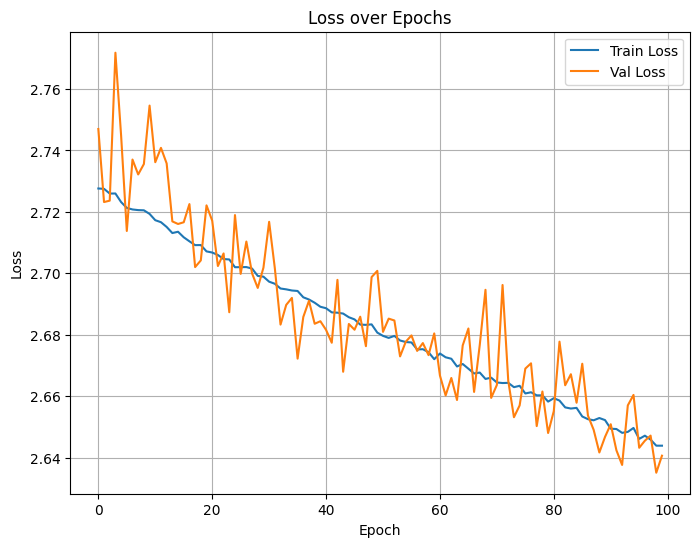

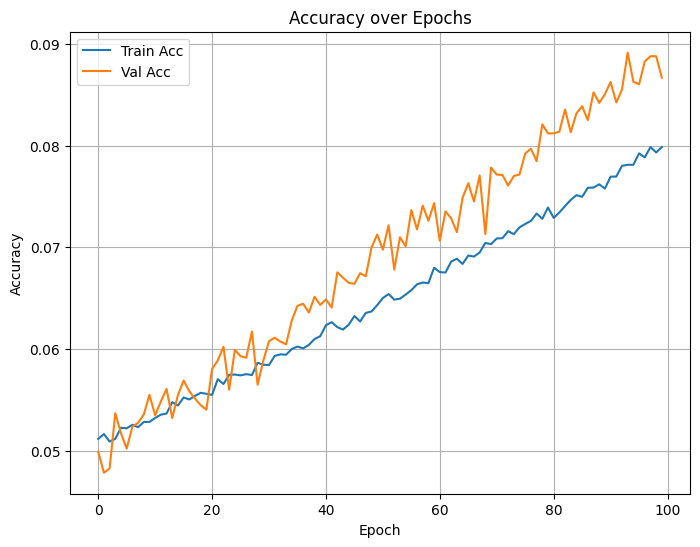

In [12]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_loss_20250519-020916_normalized_baseline.png


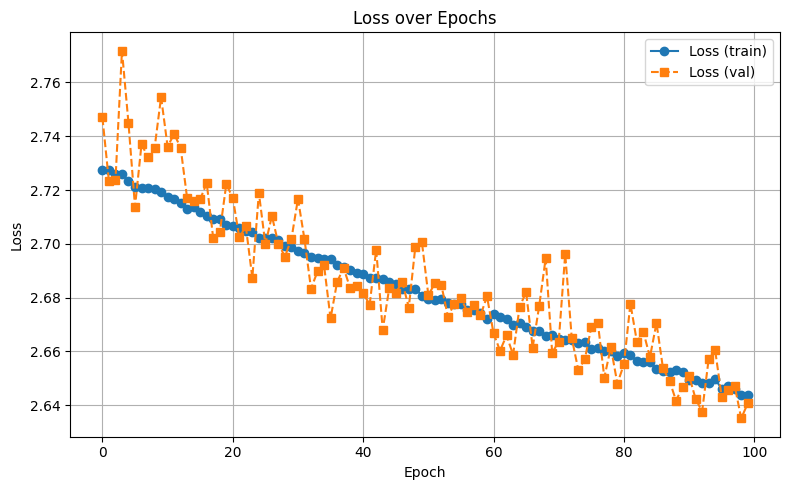

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_accuracy_20250519-020916_normalized_baseline.png


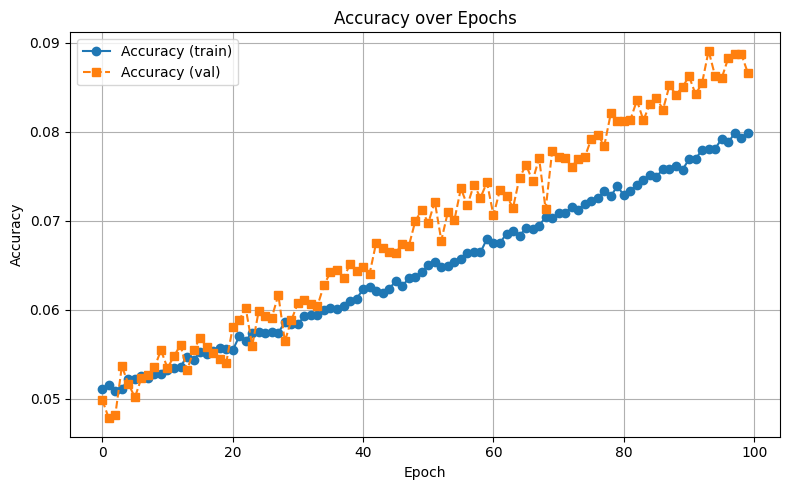

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_iou_20250519-020916_normalized_baseline.png


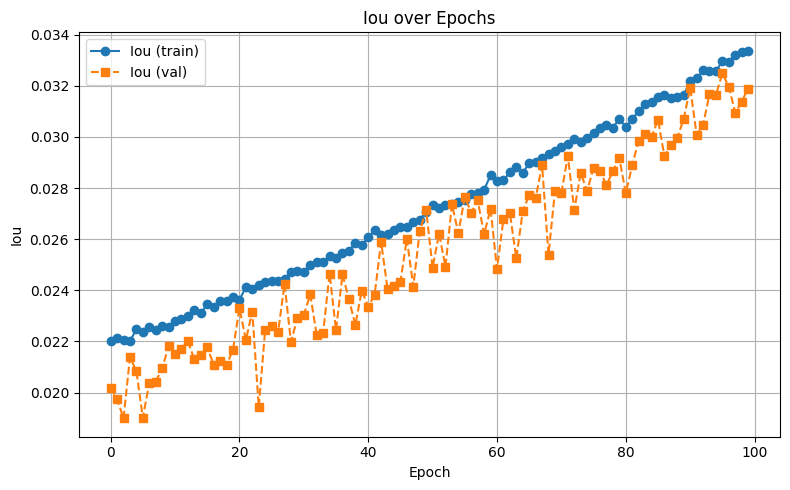

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_dice_20250519-020916_normalized_baseline.png


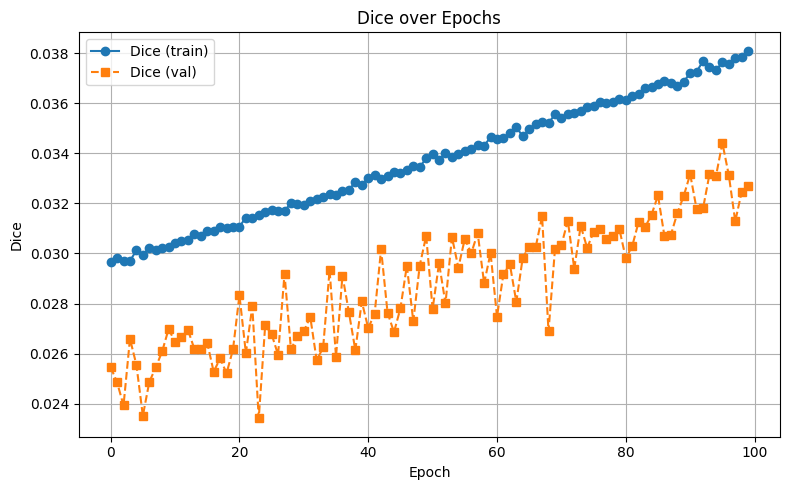

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_miou_20250519-020916_normalized_baseline.png


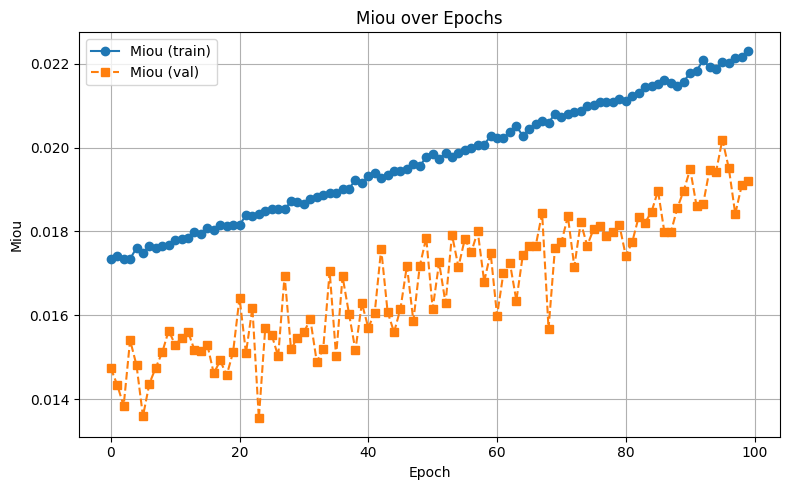

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_baseline.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [14]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_baseline.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_normalized_baseline.pth


In [15]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_baseline_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/deeplabv3+_resnet34_None_8bs_100ep_lr2e-05_normalized_baseline_metrics.csv
